In [64]:
# https://gitlab.com/ronctli1012/blog1-pretrained-alexnet-and-visualization/-/blob/master/alexnet_main.py
# https://androidkt.com/feature-extraction-from-an-image-using-pre-trained-pytorch-model/
import os
import torch
from torch import nn, utils, optim
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [65]:
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")  # check support cuda ?

image_dir = 'data'

In [66]:
#  tranformdata
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),             # resize the input to 224x224
    transforms.ToTensor(),              # put the input to tensor format
    transforms.Normalize([0.485, 0.456, 0.406], [
        0.229, 0.224, 0.225])  # normalize the input
    # the normalization is based on images from ImageNet
])

In [67]:
dataset = datasets.ImageFolder(image_dir, transform=data_transforms)
train_set, val_set = train_test_split(
    dataset, test_size=0.2, shuffle=True, random_state=43)

train_loader = utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)


In [75]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# reinit  layer
last_fc_layer_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(last_fc_layer_ftrs, len(dataset.classes))
print("model structure:", model)


model structure: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [69]:
loss_fn = nn.CrossEntropyLoss()
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


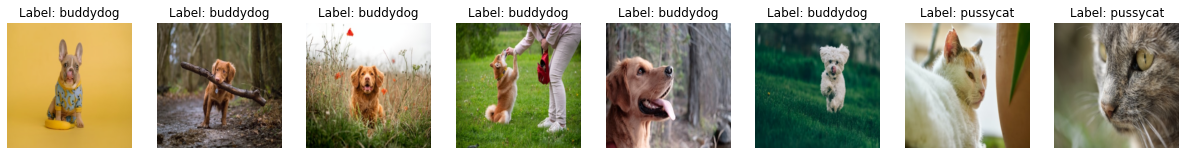

In [70]:
def showimages(imgs, actual_lbls, pred_lbls=None):

    fig = plt.figure(figsize=(21, 12))

    for i, img in enumerate(imgs):

        fig.add_subplot(4, 8, i+1)
        y = actual_lbls[i]

        if pred_lbls != None:
            y_pre = pred_lbls[i]
            title = "prediction: {0}\nlabel:{1}".format(
                dataset.classes[y], dataset.classes[y_pre])
        else:
            title = "Label: {0}".format(dataset.classes[y])

        plt.title(title)
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.axis("off")
        plt.imshow(img)

plt.show()
inputs, classes = next(iter(train_loader))
showimages(inputs, classes)


In [71]:

def train(model, loss_fn, dataloader, optimizer, epoch):
    print('\nEpoch : %d' % epoch)

    total_loss = 0
    correct = 0
    total = 0

    model.train()

    for data in tqdm(dataloader):

        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = total_loss/len(dataloader)
    accuracy = 100.*correct/total

    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f' % (loss, accuracy))

In [72]:
def test(model, loss_fn, dataloader, epoch):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss = total_loss/len(dataloader)
    accuracy = 100.*correct/total

    losses['val'].append(loss)
    accuracies['val'].append(accuracy)

    print('Test Loss: %.3f | Accuracy: %.3f' % (loss, accuracy))


In [73]:
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}
epochs = 20
for epoch in range(1, epochs+1):
    train(model, loss_fn, train_loader, optimizer_ft, epoch)
    test(model, loss_fn, val_loader, epoch)




Epoch : 1


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


Train Loss: 0.368 | Accuracy: 78.846


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Test Loss: 0.105 | Accuracy: 94.872

Epoch : 2


 55%|█████▌    | 11/20 [00:28<00:23,  2.60s/it]


KeyboardInterrupt: 

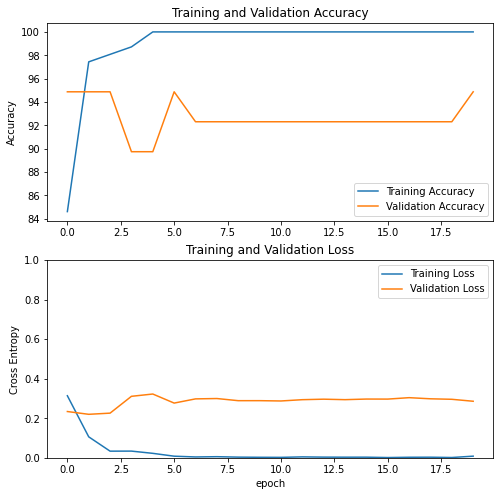

In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [77]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = data_transforms(image)
    image = Variable(image)
    image = image.float()
    image = image.unsqueeze(0)
    return image  # assumes that you're using GPU


In [78]:

image = image_loader("sample.jpg")
model.eval()
out = model(image)
print(out)



tensor([[0.2526, 0.0967]], grad_fn=<AddmmBackward>)


In [ ]:
alex = models.alexnet(pretrained=True)
alex.eval()
with open("imagenet1000_clsid_to_human.txt") as f:
    idx2label = eval(f.read())

import json
idx2label = []
cls2label = {}
with open("../../data/imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

print(labels[index[0]], percentage[index[0]].item())

print(alex(image))


tench, Tinca tinca 100.0
